# TSP
Discrete optimization:  You will have to solve the two TSP problems. 
One with 38 cities (Djibouti) and the other with 194 cities (Qatar) Data (in TSPLIB format) can be found on the following link: http://www.math.uwaterloo.ca/tsp/world/countries.html  
As a recall, your aim is to find the shortest path, so you visit all cities without visiting the same twice. 

#### Diverse notes:  
- April 8th: start; all basic functions are coded for reading and objects creation;
- April 9th: random modifications around grid search solution is implemented to improve TSP score
- April 10th: everything is recoded in numpy to make program faster  


## 1. with best next city method and for loops: a good idea but not the minimum
it allows to have a good idea of what the best travel can look like.  
it does not offer the "absolute" minimum.  
some key functions are built in this part that can be reused.  

In [1]:
import os
import numpy as np
import pandas as pd
import random
import time

In [513]:
#function 1: read tsp file and returns the info object and the points numpy array
def read_tsp(tsp_file_name,root="./raw_files"):
    infile = os.path.join(root, tsp_file_name)
    with open(infile, encoding="utf-8") as f:
        # Read instance header
        my_info=[]
        my_all_info=[]
        while my_info !=str('NODE_COORD_SECTION\n'):
            my_info = str(f.readline())
            my_all_info.append(my_info)
            
        # Read node list
        nodelist = []
        my_point =['start']
        while my_point!= []:
            my_point=f.readline().strip().split()[1:]
            nodelist.append([float(my_val) for my_val in my_point])
        f.close()
    return my_all_info,np.array(nodelist[:-1]) #to avoid the last empty point due to the while, nodellist is an np array

In [823]:
read_tsp('./qatar.tsp')

(['NAME : qa194\n',
  'COMMENT : 194 locations in Qatar\n',
  'COMMENT : Derived from National Imagery and Mapping Agency data\n',
  'TYPE : TSP\n',
  'DIMENSION : 194\n',
  'EDGE_WEIGHT_TYPE : EUC_2D\n',
  'NODE_COORD_SECTION\n'],
 array([[24748.3333, 50840.    ],
        [24758.8889, 51211.9444],
        [24827.2222, 51394.7222],
        [24904.4444, 51175.    ],
        [24996.1111, 51548.8889],
        [25010.    , 51039.4444],
        [25030.8333, 51275.2778],
        [25067.7778, 51077.5   ],
        [25100.    , 51516.6667],
        [25103.3333, 51521.6667],
        [25121.9444, 51218.3333],
        [25150.8333, 51537.7778],
        [25158.3333, 51163.6111],
        [25162.2222, 51220.8333],
        [25167.7778, 51606.9444],
        [25168.8889, 51086.3889],
        [25173.8889, 51269.4444],
        [25210.8333, 51394.1667],
        [25211.3889, 51619.1667],
        [25214.1667, 50807.2222],
        [25214.4444, 51378.8889],
        [25223.3333, 51451.6667],
        [25224.1667,

In [515]:
#function2: build the Euclidian distance matrix
def build_dist_mat(my_nodelist):
    my_dim=my_nodelist.shape[0]
    my_mat=[]
    for i in range(my_dim):
        my_line=[]
        for j in range (my_dim):
            if i == j:
                my_dist=99999
                pass
            else:
                my_dist=((my_nodelist[j][1]-my_nodelist[i][1])**2 + (my_nodelist[j][0]-my_nodelist[i][0])**2)**0.5
            my_line.append(my_dist)
        my_mat.append(my_line)
    return(np.array(my_mat)) #returns a np array of distance matrix
            

In [583]:
#function 3: find the shortest path algorithm
#step by step:
#1. pick a random start city A
#2. find the closest city B, and add the distance to total J+dist(A-B)
#3. remove the city A from the dist matrix and start again
# don't forget to add the distance from last city to first to the cost function

def my_best_travel(my_start_index,my_dist_mat):
    my_start=my_start_index
    my_mat=my_dist_mat
    my_N=my_mat.shape[0]
    my_cost=0
    my_best_solution=[]
    my_city_name=np.arange(1,my_N+1)
    my_best_solution.append(my_city_name[my_start])
    for my_index in range(my_N-1):
        my_cost+=my_mat[my_start].min()
        my_min_index=np.argmin(my_mat[my_start])
        my_best_solution.append(my_city_name[my_min_index])
        my_mat=np.delete(my_mat,my_start,axis=1)
        my_mat=np.delete(my_mat,my_start,axis=0)
        my_city_name=np.delete(my_city_name,my_start)
        if my_start<my_min_index:
            my_start=my_min_index-1
        else:
            my_start=my_min_index


    my_cost+=my_dist_mat[my_best_solution[0]-1][my_best_solution[-1]-1]
    return my_cost,np.array(my_best_solution)
        

In [568]:
#final function to loop over the start city
def my_best_sol(my_dist_mat):
    my_N=my_dist_mat.shape[0]
    my_best_cost=99999*my_N
    my_best_sol=[]
    for i in range(my_N):
        my_cost,my_solution=my_best_travel(i,my_dist_mat)
        if my_cost < my_best_cost:
            my_best_cost=my_cost
            my_best_sol=my_solution
    return my_best_cost,my_best_sol

In [569]:
#create a function to plot a node list based an order list
import matplotlib.pyplot as plt

def node_list_plot(my_node_list,my_solution):
    my_N=my_solution.shape[0]
    my_reord_nodelist=[]
    for i in range(my_N):
        my_reord_nodelist.append(my_node_list[my_solution[i]-1])
    A=pd.DataFrame(my_reord_nodelist, columns=['X','Y'])
    A['point_number']=np.array(my_solution)
    A=A.append(A.iloc[0,:])
    plt.plot(A['X'],A['Y'],'-o')   

In [570]:
def solve_tsp_1(tsp_file_name,root="./raw_files"):
    t1=time.time()
    my_cost=0
    my_sol=[]
    tsp_info,tsp_nodelist=read_tsp(tsp_file_name,root)
    my_dist_mat=build_dist_mat(tsp_nodelist)
    my_cost,my_sol=my_best_sol(my_dist_mat)
    node_list_plot(tsp_nodelist,my_sol)
    t2=time.time
    print("total computational time is ",np.round(t2-t1,4),"  seconds")
    return tsp_info,tsp_nodelist,my_cost,my_sol

(['NAME: dj38\n',
  'COMMENT : 38 locations in Djibouti\n',
  'COMMENT : Derived from National Imagery and Mapping Agency data\n',
  'COMMENT : This file is a corrected version of dj89, where duplications\n',
  'COMMENT:  have been removed.  Thanks to Jay Muthuswamy and others for\n',
  'COMMENT:  requesting data sets without duplications.\n',
  'TYPE: TSP\n',
  'DIMENSION: 38\n',
  'EDGE_WEIGHT_TYPE: EUC_2D\n',
  'NODE_COORD_SECTION\n'],
 array([[11003.6111, 42102.5   ],
        [11108.6111, 42373.8889],
        [11133.3333, 42885.8333],
        [11155.8333, 42712.5   ],
        [11183.3333, 42933.3333],
        [11297.5   , 42853.3333],
        [11310.2778, 42929.4444],
        [11416.6667, 42983.3333],
        [11423.8889, 43000.2778],
        [11438.3333, 42057.2222],
        [11461.1111, 43252.7778],
        [11485.5556, 43187.2222],
        [11503.0556, 42855.2778],
        [11511.3889, 42106.3889],
        [11522.2222, 42841.9444],
        [11569.4444, 43136.6667],
        [1158

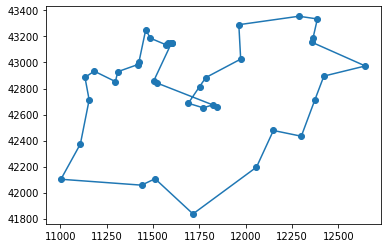

In [584]:
solve_tsp_1('djibouti.tsp')

(['NAME : qa194\n',
  'COMMENT : 194 locations in Qatar\n',
  'COMMENT : Derived from National Imagery and Mapping Agency data\n',
  'TYPE : TSP\n',
  'DIMENSION : 194\n',
  'EDGE_WEIGHT_TYPE : EUC_2D\n',
  'NODE_COORD_SECTION\n'],
 array([[24748.3333, 50840.    ],
        [24758.8889, 51211.9444],
        [24827.2222, 51394.7222],
        [24904.4444, 51175.    ],
        [24996.1111, 51548.8889],
        [25010.    , 51039.4444],
        [25030.8333, 51275.2778],
        [25067.7778, 51077.5   ],
        [25100.    , 51516.6667],
        [25103.3333, 51521.6667],
        [25121.9444, 51218.3333],
        [25150.8333, 51537.7778],
        [25158.3333, 51163.6111],
        [25162.2222, 51220.8333],
        [25167.7778, 51606.9444],
        [25168.8889, 51086.3889],
        [25173.8889, 51269.4444],
        [25210.8333, 51394.1667],
        [25211.3889, 51619.1667],
        [25214.1667, 50807.2222],
        [25214.4444, 51378.8889],
        [25223.3333, 51451.6667],
        [25224.1667,

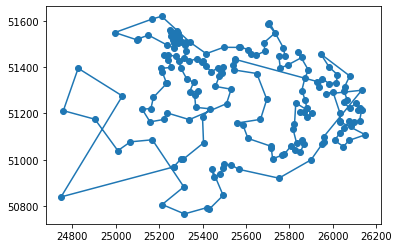

In [585]:
solve_tsp_1('qatar.tsp')

## 2. with heuristics stochastic method: random 2 by 2 swap of an existing solution with different ways of doing it

In [714]:
# we need other functions
# first: a random solution initiator = a list of the cities index where every city appear only once
def sol_gen(my_nodelist):
    my_dim=my_nodelist.shape[0]
    my_list=[i for i in range(my_dim)]
    my_sol=[]
    for j in range(my_dim):
        my_dim2=my_dim-j
        rand_index=int(random.randrange(my_dim2))
        A=my_list[rand_index]
        my_sol.append(A)
        my_list.remove(A)
    return np.array(my_sol)

In [599]:
#then we need a cost function that computes cost based on a solution list and the matrix
# we will use a for loop
#works with indices not with city numbers

def cost_compute(my_solution, a_dist_mat):
    my_mat=a_dist_mat
    my_dim=my_mat.shape[0]
    my_cost=0
    for i in range(my_dim):
        A=0
        if i == my_dim-1:
            C=my_mat[my_solution[i]][my_solution[0]]
        else:
            C=my_mat[my_solution[i]][my_solution[i+1]]
        my_cost+=C
    return my_cost

In [788]:
# we also need a random solution modifier: 
# sol_modif1= swap 2 consecutive cities in the list
#works with index not city number
def sol_modif1(my_solution):
    my_dim=my_solution.shape[0]
    my_sol_modif=[i for i in my_solution]
    index = random.randrange(my_dim)
    if index==my_dim-1:
        my_sol_modif[0]=my_solution[index]
        my_sol_modif[index]=my_solution[0]
    else:   
        my_sol_modif[index]=my_solution[index+1]
        my_sol_modif[index+1]=my_solution[index]
    return np.array(my_sol_modif)

#sol_modif2 = reshuffle a portion of N consecutive cities in the list
def sol_modif2(my_solution, my_N=5):
    my_dim=my_solution.shape[0]
    my_sol_modif=[i for i in my_solution]
    index = random.randrange(my_dim-my_N)
    my_block=[my_solution[j] for j in range(index,index+my_N)]
    my_new_block=[]
    for i in range(my_N):
        my_dim2=my_N-i
        rand_index=int(random.randrange(my_dim2))
        A=my_block[rand_index]
        my_new_block.append(A)
        my_block.remove(A)
    for i in range(my_N):
        my_sol_modif[i+index]=my_new_block[i]  
    return np.array(my_sol_modif)

#sol_modif3 = exchange 2 random cities separated from a random distance
def sol_modif3(my_solution):
    my_dim=my_solution.shape[0]
    my_sol_modif=[i for i in my_solution]
    index1 = random.randrange(my_dim)
    index2 = random.randrange(my_dim)
    if index2 == index1:
        index2=index1 +1
    if index2==my_dim:
        index2=0 
    my_sol_modif[index1]=my_solution[index2]
    my_sol_modif[index2]=my_solution[index1]
    return np.array(my_sol_modif)

In [660]:
#then the solve function with a random trial
def solve_tsp_2(tsp_file_name,root="./raw_files",nb_trial=100,block_size=6):
    my_cost=0
    my_sol=[]
    tsp_info,tsp_nodelist=read_tsp(tsp_file_name,root)
    my_dist_mat=build_dist_mat(tsp_nodelist)
    #my_sol=sol_gen(tsp_nodelist)
    #my_cost=cost_compute(my_sol, my_dist_mat)
    my_cost,my_sol=my_best_sol(my_dist_mat)
    my_best_cost=my_cost
    a_sol=my_sol-1 #array of index starts at 0
    test_sol=a_sol
    my_final_sol=my_sol-1 #array of index number, starts at 1
    trials=0
    my_block_size=block_size
    for i in range(nb_trial):
        a_cost=cost_compute(test_sol, my_dist_mat)
        if a_cost<my_best_cost:
            my_best_cost=a_cost
            my_final_sol=test_sol
            print(i,my_best_cost)
            trials=0
        #test_sol=sol_modif2(my_final_sol,my_block_size)
        test_sol=sol_modif3(my_final_sol)
        if trials > 20:
            test_sol=sol_modif2(my_final_sol,my_block_size)
            trials=0
        elif trials > 10:
            test_sol=sol_modif3(my_final_sol)
        else:
            test_sol=sol_modif1(my_final_sol) 
        trials+=1

    my_final_sol=my_final_sol+1 #array of city number
    node_list_plot(tsp_nodelist,my_final_sol)
    return tsp_info,tsp_nodelist,my_best_cost,my_final_sol

94 6762.965724246171
3182 6720.965180744795
3233 6715.6302438639495
3297 6664.113570564626
6658 6663.734223656004
6703 6660.427162818366
6704 6659.9067403867575
6810 6659.431532931464


(['NAME: dj38\n',
  'COMMENT : 38 locations in Djibouti\n',
  'COMMENT : Derived from National Imagery and Mapping Agency data\n',
  'COMMENT : This file is a corrected version of dj89, where duplications\n',
  'COMMENT:  have been removed.  Thanks to Jay Muthuswamy and others for\n',
  'COMMENT:  requesting data sets without duplications.\n',
  'TYPE: TSP\n',
  'DIMENSION: 38\n',
  'EDGE_WEIGHT_TYPE: EUC_2D\n',
  'NODE_COORD_SECTION\n'],
 array([[11003.6111, 42102.5   ],
        [11108.6111, 42373.8889],
        [11133.3333, 42885.8333],
        [11155.8333, 42712.5   ],
        [11183.3333, 42933.3333],
        [11297.5   , 42853.3333],
        [11310.2778, 42929.4444],
        [11416.6667, 42983.3333],
        [11423.8889, 43000.2778],
        [11438.3333, 42057.2222],
        [11461.1111, 43252.7778],
        [11485.5556, 43187.2222],
        [11503.0556, 42855.2778],
        [11511.3889, 42106.3889],
        [11522.2222, 42841.9444],
        [11569.4444, 43136.6667],
        [1158

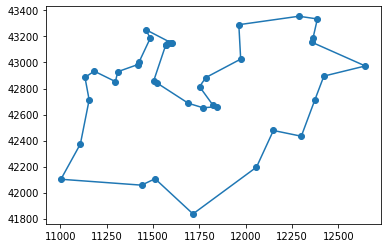

In [655]:
solve_tsp_2('djibouti.tsp',nb_trial=100000)

70 11323.300639109098
157 11320.566112213139
286 11317.3386717713
295 11312.899957694395
365 11312.242341392148
540 11288.028389421703
563 11284.885143500085
676 11255.551153758553
1364 11119.89670789485
1368 11092.354047554914
4267 11082.507688455496
4796 11078.001740738297
5191 11043.4589105804
9745 11037.59771774658
14114 11031.70913249603
14137 11030.474801168913
25289 11027.554199407909
25463 11022.28177289123
45806 10979.966760950121
48096 10973.846724852325
68173 10959.792751464882
68266 10919.64172709328
80090 10915.917109967058
80181 10911.98167802887
80376 10911.976384041016
88273 10910.16346710702
Wall time: 24.2 s


(['NAME : qa194\n',
  'COMMENT : 194 locations in Qatar\n',
  'COMMENT : Derived from National Imagery and Mapping Agency data\n',
  'TYPE : TSP\n',
  'DIMENSION : 194\n',
  'EDGE_WEIGHT_TYPE : EUC_2D\n',
  'NODE_COORD_SECTION\n'],
 array([[24748.3333, 50840.    ],
        [24758.8889, 51211.9444],
        [24827.2222, 51394.7222],
        [24904.4444, 51175.    ],
        [24996.1111, 51548.8889],
        [25010.    , 51039.4444],
        [25030.8333, 51275.2778],
        [25067.7778, 51077.5   ],
        [25100.    , 51516.6667],
        [25103.3333, 51521.6667],
        [25121.9444, 51218.3333],
        [25150.8333, 51537.7778],
        [25158.3333, 51163.6111],
        [25162.2222, 51220.8333],
        [25167.7778, 51606.9444],
        [25168.8889, 51086.3889],
        [25173.8889, 51269.4444],
        [25210.8333, 51394.1667],
        [25211.3889, 51619.1667],
        [25214.1667, 50807.2222],
        [25214.4444, 51378.8889],
        [25223.3333, 51451.6667],
        [25224.1667,

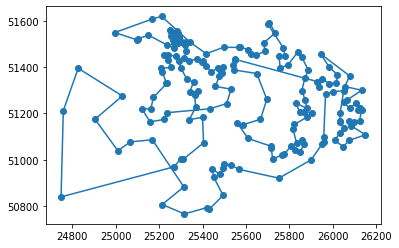

In [665]:
%%time
solve_tsp_2('qatar.tsp',nb_trial=100000)

# 3.with Metaheuristics methods to overcome local minimums  
### We add an algorithm layer that allows to overcome the local minimums  
1. tabu search by storing all the combinations tested to avoid "test" twice the same
2. Simulated annealing or GA or bird swarn

### 3.1 using simulated annealing

In [681]:
import scipy
from scipy.optimize import minimize
import math
from random import uniform

In [816]:
def simulated_annealing (cost_func, a_dist_mat, init_state, init_T, alpha, final_T, max_iter, modif_func):
    random.seed()
    count=1
    count2=1
    my_score=[]
    my_state =[]
    my_best_energy_plot=[]
    my_T=init_T
    current_state=init_state
    my_best_energy=cost_func(current_state,a_dist_mat)
    my_best_X=current_state
    while (my_T>final_T):
        new_state = modif_func(current_state)
        energy_delta= (cost_func(new_state,a_dist_mat)-cost_func(current_state,a_dist_mat))
        count2+=1
        if energy_delta < 0 :
            current_state = new_state
            my_energy=cost_func(new_state,a_dist_mat)
            if my_energy < my_best_energy:
                my_best_X=new_state
                my_best_energy=my_energy
                print(count,my_best_energy)
                count2=1
        else:
            proba = math.exp(-1*energy_delta/(my_T))
            my_rand_value=uniform(0,1)
            if my_rand_value>proba:
                current_state = new_state
        my_T=my_T*alpha
        count+=1
        
        if count>max_iter:
            break
        if count2>100000:
            break
        my_score.append(cost_func(current_state,a_dist_mat))
        my_state.append(current_state)
        my_best_energy_plot.append(my_best_energy)
        
    return my_best_X, count, my_score, my_best_energy, my_state,my_best_energy_plot

In [817]:
def solve_tsp_3(tsp_file_name,init_T, alpha, final_T, max_iter,root="./raw_files", my_N=10):
    my_cost=0
    my_sol=[]
    tsp_info,tsp_nodelist=read_tsp(tsp_file_name,root)
    my_dist_mat=build_dist_mat(tsp_nodelist)
    my_cost,my_sol=my_best_sol(my_dist_mat)
    #my_best_cost=my_cost
    #my_sol=sol_gen(tsp_nodelist)
    a_sol=my_sol-1 #array of index starts at 0
    my_best_X0=a_sol
    for i in range(my_N):
        print('epoch'+str(i))
        my_best_X1, count, my_score, my_best_energy, my_state,my_best_energy_plot=simulated_annealing(cost_compute,my_dist_mat,my_best_X0, init_T, alpha, final_T, max_iter, sol_modif3)
        my_best_X2, count, my_score, my_best_energy, my_state,my_best_energy_plot=simulated_annealing(cost_compute,my_dist_mat,my_best_X1, init_T, alpha, final_T, max_iter,sol_modif1)
        my_best_X3, count, my_score, my_best_energy, my_state,my_best_energy_plot=simulated_annealing(cost_compute,my_dist_mat,my_best_X2, init_T, alpha, final_T, max_iter,sol_modif2)
        my_best_X0=my_best_X3    
    my_final_sol=my_best_X1+1 #array of city number
    node_list_plot(tsp_nodelist,my_final_sol)
    my_best_cost=cost_compute(my_best_X3,my_dist_mat)
    return tsp_info,tsp_nodelist,my_best_cost,my_final_sol

epoch0
567 6762.620611390532
854 6715.6302438639495
1867 6664.113570564626
128 6663.734223656004
516 6661.468582980932
1047 6659.9067403867575
2370 6659.431532931464
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9


(['NAME: dj38\n',
  'COMMENT : 38 locations in Djibouti\n',
  'COMMENT : Derived from National Imagery and Mapping Agency data\n',
  'COMMENT : This file is a corrected version of dj89, where duplications\n',
  'COMMENT:  have been removed.  Thanks to Jay Muthuswamy and others for\n',
  'COMMENT:  requesting data sets without duplications.\n',
  'TYPE: TSP\n',
  'DIMENSION: 38\n',
  'EDGE_WEIGHT_TYPE: EUC_2D\n',
  'NODE_COORD_SECTION\n'],
 array([[11003.6111, 42102.5   ],
        [11108.6111, 42373.8889],
        [11133.3333, 42885.8333],
        [11155.8333, 42712.5   ],
        [11183.3333, 42933.3333],
        [11297.5   , 42853.3333],
        [11310.2778, 42929.4444],
        [11416.6667, 42983.3333],
        [11423.8889, 43000.2778],
        [11438.3333, 42057.2222],
        [11461.1111, 43252.7778],
        [11485.5556, 43187.2222],
        [11503.0556, 42855.2778],
        [11511.3889, 42106.3889],
        [11522.2222, 42841.9444],
        [11569.4444, 43136.6667],
        [1158

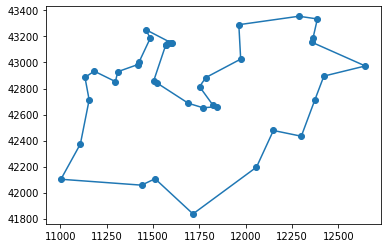

In [813]:
solve_tsp_3('djibouti.tsp',1E22, 0.99999999, 0.1, 100000,root="./raw_files")

epoch0
561 11301.059206683683
1504 11286.706899867067
2190 11279.179381321625
2392 11270.895058178749
3757 11247.31791077549
4396 11212.49132069663
6259 11205.996692793118
7722 11184.528173184948
9352 11181.793646288988
12840 11101.734396278009
14420 11028.142722069202
15964 11027.485105766953
17830 11025.411753789484
21573 11019.821063275542
24315 11016.677817353924
28111 11012.239103277021
32048 11006.377910443198
35693 10971.658952691912
36299 10968.498619848724
38416 10967.69546673496
41883 10945.717059307217
42269 10945.318953951893
58519 10944.697221738814
88920 10943.246007695754
93640 10938.164857510206
856 10937.965167213344
1116 10936.19753916618
1404 10920.26791033861
3815 10913.048938385833
4275 10907.153044153196
4433 10857.076248134526
4864 10833.528295592763
6110 10832.127291957788
6127 10827.61447752035
6240 10822.444593611513
7534 10813.276221183554
18160 10796.441475371625
19607 10796.34919846367
20845 10795.448654885555
21863 10753.133642944447
22592 10748.7691913491

(['NAME : qa194\n',
  'COMMENT : 194 locations in Qatar\n',
  'COMMENT : Derived from National Imagery and Mapping Agency data\n',
  'TYPE : TSP\n',
  'DIMENSION : 194\n',
  'EDGE_WEIGHT_TYPE : EUC_2D\n',
  'NODE_COORD_SECTION\n'],
 array([[24748.3333, 50840.    ],
        [24758.8889, 51211.9444],
        [24827.2222, 51394.7222],
        [24904.4444, 51175.    ],
        [24996.1111, 51548.8889],
        [25010.    , 51039.4444],
        [25030.8333, 51275.2778],
        [25067.7778, 51077.5   ],
        [25100.    , 51516.6667],
        [25103.3333, 51521.6667],
        [25121.9444, 51218.3333],
        [25150.8333, 51537.7778],
        [25158.3333, 51163.6111],
        [25162.2222, 51220.8333],
        [25167.7778, 51606.9444],
        [25168.8889, 51086.3889],
        [25173.8889, 51269.4444],
        [25210.8333, 51394.1667],
        [25211.3889, 51619.1667],
        [25214.1667, 50807.2222],
        [25214.4444, 51378.8889],
        [25223.3333, 51451.6667],
        [25224.1667,

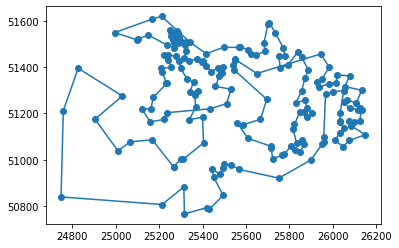

In [821]:
%%time
solve_tsp_3('qatar.tsp',1E36, 0.999999999999999, 1, 1000000,root="./raw_files", my_N=5)